# Slopes for Simulated Videos

#### Everything should now be in order, run to find elasticity map for "test2percent" video.

In [3]:
#import functions

import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from skimage.morphology import skeletonize
import skimage.io
from sklearn.mixture import GaussianMixture as GMM
from sklearn.linear_model import LinearRegression
from sklearn import mixture
from sklearn.cluster import DBSCAN

from functions import *
from wave_detection.line_detection_gmm import *

In [4]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y


In [5]:
#DBScan clustering
class WaveDetector:
    def __init__(self, corr_image, peak_threshold=150):
    # def __init__(self, data_file, peak_threshold=30):    
        # self.correlation = np.genfromtxt(data_file, delimiter=',')
        self.correlation = corr_image

        self.n_pos = self.correlation.shape[0]
        self.n_time = self.correlation.shape[1]

        # Extract wave tip points with corresponding range of [0, 1] for position and time
        self.ind_siginificant = (self.correlation > peak_threshold)
        # self.ind_siginificant = (self.correlation < peak_threshold)

        # Step-size of 1 between position and time worked out to be optimal
        self.x_lim = [0, self.n_time]
        self.y_lim = [0, self.n_pos]
        
        time_vals, pos_vals = np.meshgrid(
            np.linspace(self.x_lim[0], self.x_lim[-1], self.n_time),
            np.linspace(self.y_lim[0], self.y_lim[-1], self.n_pos),
        )

        self.data = np.vstack((
            time_vals.flatten(),
            pos_vals.flatten(),
            # time_vals.flatten(),
        ))[:, self.ind_siginificant.flatten()]

        # self.data = self.data.T
        #self.do_dbscan()
        self.do_gmm_clustering()
    
    def do_dbscan(self, eps = 2, min_samples = 5, x_stretching = 1, do_plotting = False):
        self.temp_data = np.copy(self.data)
        self.temp_data[0,:] = self.data[0,:]*x_stretching
        self.dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(self.temp_data.T)
        self.unique_labels = set(self.dbscan.labels_)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(self.unique_labels))]
        
        for k, col in zip(self.unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = self.dbscan.labels_ == k

            xy = self.temp_data.T[class_member_mask]
            if do_plotting:
                plt.plot(
                    xy[:, 0],
                    xy[:, 1],
                    ".",
                    color=tuple(col),
                    markersize=14,
                    )
                plt.axis('equal')
            
    def do_linear_regression(self):
        reg_coeffs = []

        for label in self.unique_labels:
            if label == -1:
                continue

            class_member_mask = self.dbscan.labels_ == label

            xy = self.data.T[class_member_mask]
            reg = LinearRegression().fit(xy[:,0].reshape(-1, 1), xy[:,1].reshape(-1, 1))
            reg_coeffs.append(reg.coef_)

        return np.mean(reg_coeffs)

        
    def do_gmm_clustering(self, n_gmm=4):
        self.gmm = mixture.GaussianMixture(
            n_components=n_gmm,
            covariance_type="full",
            max_iter=100
        ).fit(self.data.T)
        
    


    def do_slope_estimation(self, rel_weight_margin=0.1, color='#ADD8E6', plot_results=False):
        # TODO: Pre-processing to remove ellipses which are in the upper left or bottom -> Done
        # self.count = []

        # for ii, mean in enumerate(self.gmm.means_):
        #     if mean[1] <= self.n_pos/2 and mean[0] <= self.n_time/3:
        #     # if mean[1] >= 80:
        #         self.count.append(ii)
        # self.gmm.means_ = np.delete(self.gmm.means_, self.count, 0)
        # self.gmm.covariances_ = np.delete(self.gmm.covariances_, self.count, 0)
        # self.gmm.weights_ = np.delete(self.gmm.weights_, self.count, 0)

        
        max_weight = np.max(self.gmm.weights_)

        if plot_results:
            # Plot only relevant clusters
            fig, ax = plt.subplots()

        self.slopes = []
        self.weights = []
        
        for ii, (mean, covar) in enumerate(zip(self.gmm.means_, self.gmm.covariances_)):
            # Neglect clusteres with only few points
            if self.gmm.weights_[ii] < rel_weight_margin * max_weight:
                continue
    
            # Eigen values are in ascending order -> last eigenvector is important!
            eig_vals, eig_vecs = linalg.eigh(covar)

            eig_vals = 2.0 * np.sqrt(2.0) * np.sqrt(eig_vals)
            uu = eig_vecs[0] / linalg.norm(eig_vecs[0])

            if any(eig_vecs[-1, :] < 1e-3):
                continue
            elif any(eig_vecs[-1, :] > 100):
                continue
            self.weights.append(self.gmm.weights_[ii])
            self.slopes.append(eig_vecs[-1, :] / linalg.norm(eig_vecs[-1, :]))
                    # self.slopes.append([-uu[1], uu[0]])

            if plot_results:
                        # Plot an ellipse to show the Gaussian component
                        angle = np.arctan2(uu[1], uu[0])
                        angle = 180.0 * angle / np.pi  # convert to degrees
                        ell = mpl.patches.Ellipse(mean, eig_vals[0], eig_vals[1], angle, color=color)
                        ell.set_clip_box(ax.bbox)
                        ell.set_alpha(0.5)
                        ax.add_artist(ell)
                
                # Get mean
            self.slopes = np.array(self.slopes).T

                # Check which slopes are pointing downwards
            ind_neg = (self.slopes[1, :] < 0)
            self.slopes[1, ind_neg] *= (-1)

                # Normalize weights
            self.weights = self.weights / np.sum(self.weights)
                
            self.mean_slope = np.sum(
                self.slopes * np.tile(self.weights, (self.slopes.shape[0], 1)), axis=1
                )

            slope = self.mean_slope[1] / self.mean_slope[0]

            if plot_results:
                    ax.scatter(self.data[0, :], self.data[1, :], color='k')
                    # ax.scatter([], [], color='k')
                    self.x_lim = ax.get_xlim()
                    self.y_lim = ax.get_ylim()

                    y1 = self.y_lim[0] + (self.x_lim[1] - self.x_lim[0]) * slope

                    ax.plot(self.x_lim, np.array([self.y_lim[0], y1]) + 0, '--', color='r',
                            linewidth=2, label=f"{round(slope, 6)} m / s")

                    ax.set_xlim(self.x_lim)
                    ax.set_ylim(self.y_lim)

                    ax.legend()

            return slope

    def plot_all_clusters(self, color='#ADD8B6'):
        fig, ax = plt.subplots()

        ax.scatter(self.data[0, :], self.data[1, :], color='k')
        
        for ii, (mean, covar) in enumerate(zip(self.gmm.means_, self.gmm.covariances_)):
            v, w = linalg.eigh(covar)
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

In [ ]:
# #ONLY RUN ONCE
# #making folders
# os.mkdir('sim_2perc')
# os.mkdir('sim_2perc_crop')

In [89]:
# #ONLY RUN ONCE
# #extracting frames from the simulated 2 percent G1100 video
# video_name = 'test2percent_G1100_cut'
# path_to_source = 'data/' + video_name + '.avi'
# cap = cv.VideoCapture(path_to_source)
# num_frames = 50
# l=0
# m=0
# while l <= num_frames:
#     ret, frame = cap.read()
#     if not ret: 
#         print('No frames grabbed!')
#         break
#     cv.imwrite(f'sim_2perc/{m}.jpg', frame)
#     l+=1
#     m+=1

In [ ]:
# #ONLY RUN ONCE
# # crop images for faster calculation 
# data_path = 'sim_2perc/'
# data_save = 'sim_2perc_crop/'
# x_start = 50
# x_end = 100
# y_start = 5
# y_end = 55
# crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

15
[[  1.           1.           1.           1.          21.4
   32.875       67.52173913 115.75       202.31578947 256.
  256.         256.         256.         234.75       224.125     ]
 [  9.22580645   1.           1.           1.          21.4
   32.875       56.43478261 115.75       175.47368421 241.83333333
  256.         245.375      256.         234.75       224.125     ]
 [  9.22580645   9.5          1.           1.          21.4
   32.875       56.43478261 103.         148.63157895 227.66666667
  256.         245.375      256.         245.375      224.125     ]
 [ 17.4516129   18.           9.79310345   1.          11.2
   22.25        45.34782609  90.25       148.63157895 213.5
  243.85714286 234.75       244.40909091 245.375      234.75      ]
 [ 25.67741935  18.           9.79310345   1.          11.2
   22.25        34.26086957  77.5        148.63157895 199.33333333
  231.71428571 224.125      244.40909091 245.375      234.75      ]
 [ 33.90322581  26.5         18.58620

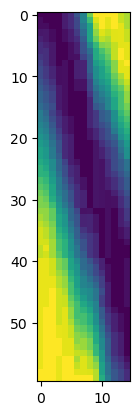

In [174]:
# implement slope measurement for one pixel
# 50x50 pixels
#itterate through each pixel to get a correlation result


frNum = 15
path_to_images = 'sim_2perc_crop/'
kernel = 1
threshold_bin = 0

pixel_x = pixel_y = 50
pixel_array = []
for x in range(0, pixel_x + 1):
     for y in range(0, pixel_y + 1):
        pixel = [pixel_x, pixel_y]
pixel_array.append(pixel)         
         
#corr_full_y is 60x15 matrix which represents one pixel      
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel_array[0], kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)
print(corr_full_y.shape[1])
print(corr_full_y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


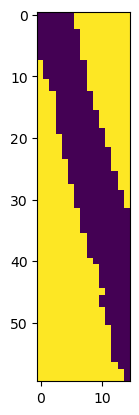

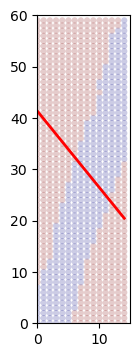

In [175]:
#clean version
T=50
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)
#print(image)

#flip matrix (mirrored image)
mirror_image = np.fliplr(image)
#print(mirror_image)

#using clean version to fit a line
z = image
y, x = np.indices(z.shape)
valid_z = (y.ravel()>=0) & (z.ravel()>=0)
x_valid = x.ravel()[valid_z]
y_valid = y.ravel()[valid_z]
z_valid = z.ravel()[valid_z]
# fitting best curve
fig = plt.figure(figsize=(1.2,4))
ax = fig.add_subplot(111)
ax.scatter(x_valid, y_valid, c=z_valid, alpha=0.2, s=20, edgecolor='none',
        cmap=plt.cm.jet)
# finding best-fit curve
z = np.polyfit(x_valid, y_valid, w=z_valid**0.5, deg=1)
p = np.poly1d(z)
# plotting
x_plot = np.linspace(x_valid.min(), x_valid.max(), 100)
y_plot = p(x_plot)
ax.plot(x_plot, y_plot, 'r-', lw=2)
ax.set_xlim(0, x.shape[1])
ax.set_ylim(0, y.shape[0])

ax.legend(loc='lower left', frameon=False, fontsize=8)
#fig.savefig('test.png', bbox_inches='tight')


In [143]:
# Save the Numpy array as Image
image_filename = "image0.jpeg"
saved_image = plt.imsave(fname=image_filename, arr=image)


#save mirrored image
mirror_image_filename = "imageM.jpeg"
mirrored_saved_image = plt.imsave(fname=mirror_image_filename, arr=mirror_image)

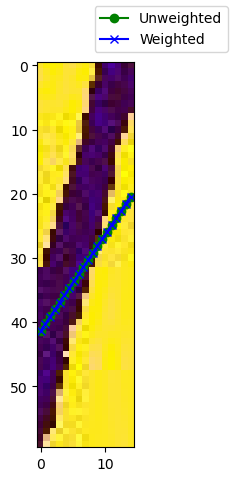

In [176]:
# https://stackoverflow.com/questions/52802648/how-do-i-fit-a-line-to-a-cluster-of-pixels

#Method 2: Fitting a line to clean cross correlation results

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def feature(x, order=3):
    """Generate polynomial feature of the form
    [1, x, x^2, ..., x^order] where x is the column of x-coordinates
    and 1 is the column of ones for the intercept.
    """
    x = x.reshape(-1, 1)
    return np.power(x, np.arange(order+1).reshape(1, -1)) 

I_orig = plt.imread("image0.jpeg")
I_mirror = plt.imread("imageM.jpeg")
# Convert to grayscale
I = rgb2gray(I_orig)

# Mask out region
mask = I > 100

# Get coordinates of pixels corresponding to marked region
X = np.argwhere(mask)

# Use the value as weights later
weights = I[mask] / float(I.max())
# Convert to diagonal matrix
W = np.diag(weights)

# Column indices
x = X[:, 1].reshape(-1, 1)
# Row indices to predict. Note origin is at top left corner
y = X[:, 0]

# Ridge regression, i.e., least squares with l2 regularization. 
# Should probably use a more numerically stable implementation, 
# e.g., that in Scikit-Learn
# alpha is regularization parameter. Larger alpha => less flexible curve
alpha = 0.01

# Construct data matrix, A
order = 1
A = feature(x, order)
# w = inv (A^T A + alpha * I) A^T y
w_unweighted = np.linalg.pinv( A.T.dot(A) + alpha * np.eye(A.shape[1])).dot(A.T).dot(y)
# w = inv (A^T W A + alpha * I) A^T W y
w_weighted = np.linalg.pinv( A.T.dot(W).dot(A) + alpha * \
                             np.eye(A.shape[1])).dot(A.T).dot(W).dot(y)


# Generate test points
n_samples = 20
x_test = np.linspace(0, I_orig.shape[1]-1, n_samples)
X_test = feature(x_test, order)

# Predict y coordinates at test points
y_test_unweighted = X_test.dot(w_unweighted)
y_test_weighted = X_test.dot(w_weighted)

# Display
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
ax.imshow(I_mirror)
ax.plot(x_test, y_test_unweighted, color="green", marker='o', label="Unweighted")
ax.plot(x_test, y_test_weighted, color="blue", marker='x', label="Weighted")
fig.legend()


In [92]:
#blurred version
# blur = cv.GaussianBlur(image, (3, 3), 0)
# plt.imshow(blur)

In [9]:
#blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)
blur_norm = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX)

In [10]:
plt.close('all')
plt.ion()
my_detector = WaveDetector(corr_image=blur_norm)
#my_detector.plot_all_clusters()


[0.45198245]
[0.45198245 0.45983361]


(-3.0, 63.0, -3.9973135140592766, 63.04749111971711)

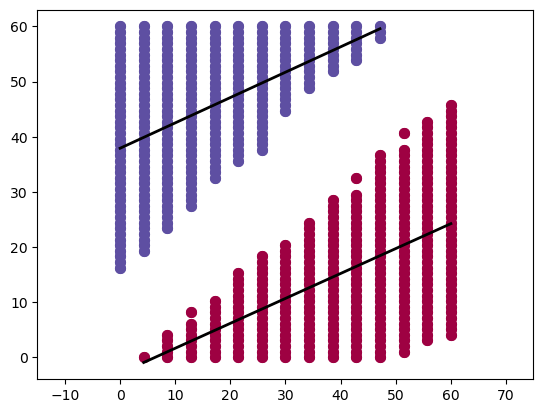

In [18]:
#using DBSCAN clustering method, groups lines by colour and plot lines of best fit FOR ONE PIXEL
my_detector.do_dbscan(eps =8, min_samples = 12, x_stretching = 4, do_plotting = True)
unique_labels = set(my_detector.dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
slope_array = []
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = my_detector.dbscan.labels_ == k

    xy = my_detector.temp_data.T[class_member_mask]
    x_tuple = xy[:, 0],
    y_tuple = xy[:, 1],

    plt.plot(
        x_tuple,
        y_tuple,
        ".",
        color=tuple(col),
        markersize=14,
    )
    
    #reshape tuple into array so that it can be used in numpy expressions
    x_array=np.array(x_tuple).reshape(-1)
    y_array=np.array(y_tuple).reshape(-1)
    
    #find line of best fit
    LOB_slopes, b = np.polyfit(x_array, y_array, 1) 
    plt.plot(x_array, LOB_slopes*x_array+b, color='black', linestyle='-', linewidth=2)
    #print(line_slopes)
    slope_array.append(LOB_slopes)
    mean_slope = np.mean(slope_array)
    np_slope_array = np.array(slope_array)
    print(np_slope_array)

#find average of all LOB in each pixel
#add average to array
#make slope array into 50x50 slope matrix, match coordinate of pixel to position in matrix (0,0) => [0,0]
#from slope 

plt.axis('equal') 



[[0.45198245 0.45198245 0.45198245 ... 0.45198245 0.45198245 0.45198245]
 [0.45198245 0.45198245 0.45198245 ... 0.45198245 0.45198245 0.45198245]
 [0.45198245 0.45198245 0.45198245 ... 0.45198245 0.45198245 0.45198245]
 ...
 [0.45198245 0.45198245 0.45198245 ... 0.45198245 0.45198245 0.45198245]
 [0.45198245 0.45198245 0.45198245 ... 0.45198245 0.45198245 0.45198245]
 [0.45198245 0.45198245 0.45198245 ... 0.45198245 0.45198245 0.45198245]]


Text(0.5, 1.0, 'Slopes from LOB')

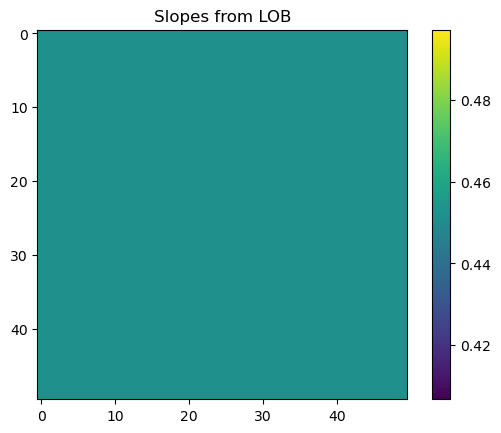

In [30]:
#plotting slopes from LOB results

#initializing empty matrix 50x50
ndarray_slopes = np.ndarray(shape=(50,50), dtype=float, order='F') # empty matrix of 50x50

#for loop to fill in matrix
for i in range(ndarray_slopes.shape[0]):
    for j in range(ndarray_slopes.shape[1]):
        ndarray_slopes[i,j] = slope_array[0]

#plots slopes for in each pixel, colorbar used as legend
print(ndarray_slopes)
plt.imshow(ndarray_slopes)
plt.colorbar()
plt.title("Slopes from LOB")

#plot with only 1 slope, need to somehow put both slopes found

In [25]:
# calculate elasticity
def elasticity_HT (slopes, dens, conv_pix, conv_fr):
    conv_factor = (conv_pix * conv_fr)
    mu = ((slopes * conv_factor)**2) * dens
    return mu

In [26]:
# Compute elasticity
dens = 1000
conv_pix = (1/2)*1e-6
conv_fr = 300000

mu = elasticity_HT(ndarray_slopes, dens, conv_pix, conv_fr)

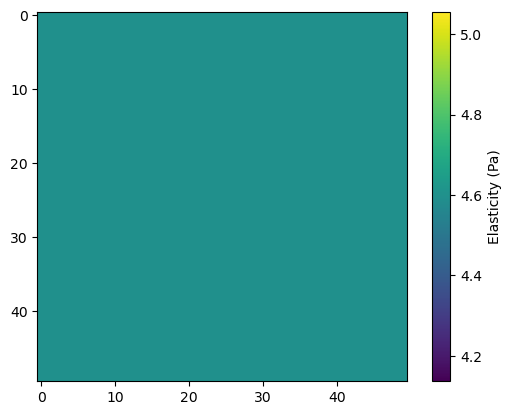

In [35]:
plt.imshow(mu)
plt.colorbar(label='Elasticity (Pa)')


In [ ]:
# #linear regression attempt (leave for now)
# ax = sns.jointplot(x=x_array, y=y_array,
#               hue=None, color='#949ba4',
#               xlim=[-3,3], ylim=[-3,3], lw=0,
#               height=10, ratio=6
#              )
# for p in unique_labels:
#     sns.regplot(x=x_array, y=y_array,
#                 color='black', ax=ax.ax_joint)

# ax.ax_marg_x.remove()
# ax.ax_marg_y.remove()

# ax = sns.regplot(x=x_array, y=y_array,
#                  color='#949ba4', ax=ax.ax_joint, scatter=False, line_kws={'linestyle': '--'})

# sns.despine(ax=None, top=True, right=True, left=True,
#                  bottom=True, offset=None, trim=False)
#plt.show()

In [108]:
# my_detector = WaveDetector(corr_image=blur_norm)
# my_detector.do_dbscan(eps =8, min_samples = 12, x_stretching = 4, do_plotting = True)

In [105]:
reg_coeffs = []

for label in unique_labels:
    if k == -1:
        continue

    class_member_mask = my_detector.dbscan.labels_ == label

    xy = my_detector.data.T[class_member_mask]
    reg = LinearRegression().fit(xy[:,0].reshape(-1, 1), xy[:,1].reshape(-1, 1))
    reg_coeffs.append(reg.coef_)
    
np.mean(reg_coeffs)

1.8236321228019108

1.9845658293528219
1.9711264019365622
1.8610827807142925
1.8319891472767909
1.779511883517406
1.8182517815821593
1.8113980656943918
1.8433942406446684
1.685376878170667
1.6349517926313888
1.6097462156113056
1.6287235942188647
1.588737808303569
1.5839854878558883
1.5999073230157594
1.591159011365344
1.6477296336539162
1.6551879501699887
1.6342534251783305
1.6383232505871859
1.6462869850809225
1.6435667994949206
1.659227648368433
1.651777036961807
1.539652379387063
1.5346569400124497
1.5572867022679961
1.5196115741532648
1.5388133834454227
1.5068718405043882
1.5568702026337797
1.5510243225311235
1.6159471603976576
1.6362375143312389
1.6605192398924054
1.6469688665439746
1.661986532208409
1.7032283821925156
1.6401988808956889
1.6398441625903744
1.5508901002765652
1.5401127600748463
1.564604075423958
1.5841105729532958
1.5931953902837894
1.6006221988594196
1.5897509106103263
1.5875771250864927
1.6850080347435903
1.6773940455305192
1.6763204832639376
1.681082712779987
1.683758926483823
1.68

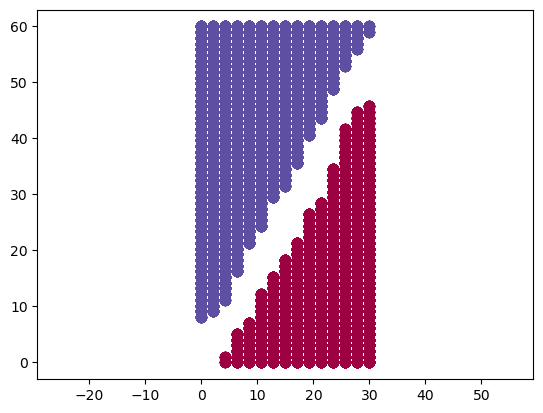

In [36]:
# Trying cropped simulated video (good video, 2 percent conc)

frNum = 15
path_to_images = 'sim_2perc_crop/'

kernel = 1
threshold_bin = 0
image_1 = cv.imread(path_to_images + '23.jpg', cv.IMREAD_GRAYSCALE)
slopes = np.zeros([image_1.shape[0], image_1.shape[1]])  # empty matrix of 50x50


for i in range(image_1.shape[0]):
    for j in range(image_1.shape[1]):
        pixel=[i, j]
        #print(pixel)
        try:
            _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
        
            T=50
            image = np.copy(corr_full_y)
            image[corr_full_y<T] = 0
            image[corr_full_y>=T] = 1
            blur = cv.GaussianBlur(image, (3, 3), 0)
            blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)
            my_detector = WaveDetector(corr_image=blur_norm)
            my_detector.do_dbscan(eps =5, min_samples = 10, x_stretching = 2, do_plotting = True)
            slope = my_detector.do_linear_regression()
        except ValueError:
            slope=None
        slopes[i, j] = slope
        print(slope)

# #find line of best fit
# m, b = np.polyfit(corr_full_x, corr_full_y, 1) 
# plt.plot(corr_full_x, m*corr_full_x+b, color='black', linestyle='--', linewidth=2)



[[1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 ...
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]
 [1.98456583 1.9711264  1.86108278 ... 1.62176467 1.61573029 1.65092878]]


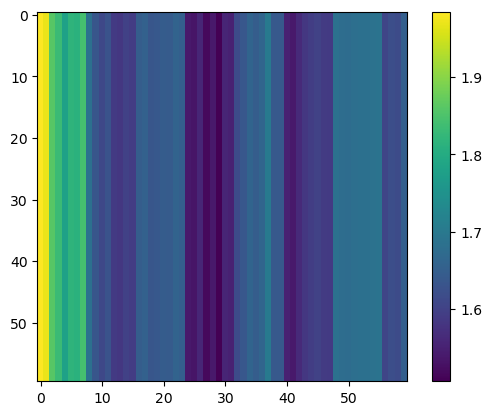

In [37]:
#plots slopes for in each pixel, colorbar used as legend
print(slopes)
plt.imshow(slopes)
plt.colorbar()


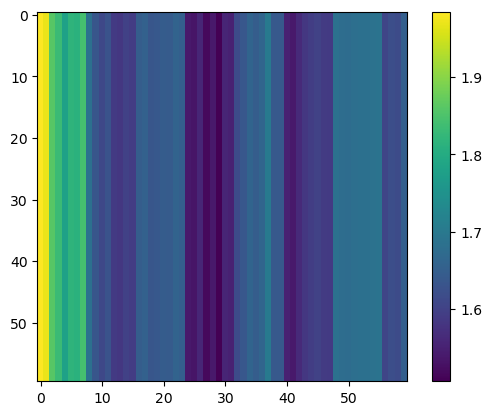

In [65]:
#making negative slopes positive, doesn't actually affect plot
new_slopes = slopes
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]<0:
            new_slopes[i,j] *= -1
plt.imshow(new_slopes)
plt.colorbar()

In [66]:
# finding median slope (positive), not including nan values
nan_array = np.isnan(new_slopes)
not_nan_array = ~ nan_array
slope_notnan = new_slopes[not_nan_array]
replacement = np.median(slope_notnan)
replacement 

1.6390837065887802

In [67]:
#same value as above
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]>100:
            new_slopes[i,j] = replacement
        elif np.isnan(new_slopes[i,j]):
            new_slopes[i,j] = replacement
new_slopes
median_of_slope_new = np.median(new_slopes)
median_of_slope_new

1.6390837065887802

In [68]:
# also same as above
nan_arrayN = np.isnan(new_slopes)
not_nan_arrayN = ~ nan_arrayN
slope_notnanN = new_slopes[not_nan_arrayN]
median_of_slope_new = np.median(slope_notnanN)
median_of_slope_new

1.6390837065887802

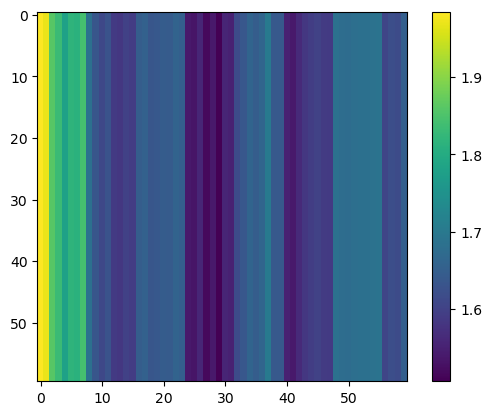

In [69]:
plt.imshow(new_slopes)
plt.colorbar()

In [70]:
# calculate elasticity
def elasticity_HT (slopes, dens, conv_pix, conv_fr):
    conv_factor = (conv_pix * conv_fr)
    mu = ((slopes * conv_factor)**2) * dens
    return mu

In [71]:
# Compute elasticity
dens = 1000
conv_pix = (1/2)*1e-6
conv_fr = 300000

mu = elasticity_HT(slopes, dens, conv_pix, conv_fr) ##THIS SHIT ISNT WORKING

In [72]:
# Get rid of nan values
nan_array = np.isnan(mu)
not_nan_array = ~ nan_array
mu_notnan = mu[not_nan_array]
np.median(mu_notnan)


60.44840944870825

In [73]:
#finding speed
speed = np.sqrt(mu_notnan/dens)
np.median(speed)

0.24586255598831702

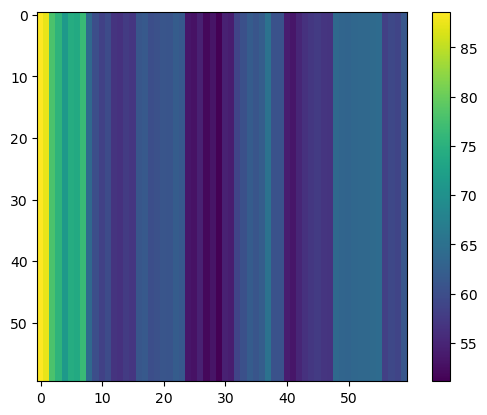

In [74]:
plt.imshow(mu)
plt.colorbar()